In [1]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

In [3]:
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np

In [4]:
def create_system_find_energy(file):

    try:
        pdb = PDBFile(file)
        forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
        system = forcefield.createSystem(pdb.topology, 
                                         # nonbondedMethod=PME,
                                         nonbondedMethod=app.NoCutoff,
                nonbondedCutoff=1*nanometer, constraints=HBonds)
        
        integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
        simulation = Simulation(pdb.topology, system, integrator)
        simulation.context.setPositions(pdb.positions)
        
        state = simulation.context.getState(getEnergy=True)
        einit = state.getPotentialEnergy()._value
    
        return einit

    except:
        print(file, ' failed')
        problematic_pdbs.append(file)
        return np.nan
    # print('----- ', file, ' -----')
    # print(f'Initial Energy: {einit}') # default units: kJ mol^-1
    # print('')

In [6]:
input_pdbs = np.sort( glob('random_conformations/AA_pdbs/*') )
problematic_pdbs = []

file_names = []
energy_lst = []

# n1 = 5850

for f in tqdm(input_pdbs):
    
    file_names.append(f.split('/')[-1])
    energy_lst.append(create_system_find_energy(f))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 9858/9858 [41:43<00:00,  3.94it/s]


In [7]:
problematic_pdbs

[]

In [46]:
df = pd.DataFrame(data={'file_name':file_names, 'Energy':energy_lst})

In [48]:
df[df['Energy'] > 1e6]

,file_name,Energy
2312,coords_2_380.pdb,1.259049e+12
5880,coords_6_118.pdb,8.978805e+10
8278,coords_8_477.pdb,1.004687e+06


In [44]:
# df = df[df['Energy'] < 1e6]

<Axes: >

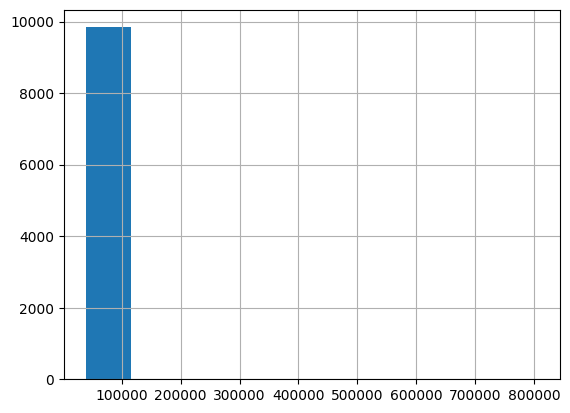

In [45]:
df['Energy'].hist()

In [47]:
df.to_csv('conformation_energy.csv', index=False)

In [11]:
for f in input_pdbs[:10]:
    create_system_find_energy(f)

-----  random_conformations/AA_pdbs/coords_8_525.pdb  -----
Initial Energy: 50074.55177307129 kJ/mol

-----  random_conformations/AA_pdbs/coords_4_75.pdb  -----
Initial Energy: 50410.433334350586 kJ/mol

-----  random_conformations/AA_pdbs/coords_3_853.pdb  -----
Initial Energy: 44882.947174072266 kJ/mol

-----  random_conformations/AA_pdbs/coords_9_842.pdb  -----
Initial Energy: 47698.57891845703 kJ/mol

-----  random_conformations/AA_pdbs/coords_0_645.pdb  -----
Initial Energy: 46788.94677734375 kJ/mol

-----  random_conformations/AA_pdbs/coords_3_158.pdb  -----
Initial Energy: 44691.55163574219 kJ/mol

-----  random_conformations/AA_pdbs/coords_5_846.pdb  -----
Initial Energy: 49887.2271194458 kJ/mol

-----  random_conformations/AA_pdbs/coords_1_808.pdb  -----
Initial Energy: 48616.68719482422 kJ/mol

-----  random_conformations/AA_pdbs/coords_7_445.pdb  -----
Initial Energy: 54967.885833740234 kJ/mol

-----  random_conformations/AA_pdbs/coords_1_6.pdb  -----
Initial Energy: 56009.0

In [ ]:
simulation.minimizeEnergy()
simulation.reporters.append(PDBReporter('output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True))
simulation.step(10000)